# `Project`: Construction of `Low` and `High` Correlation Portfolios of Risky Assets 
In this `project,` we'll explore how the correlation of asset return influences the `efficient frontier` computed by solving the minimum variance allocation problem initially proposed by [Markowitz, 1952](https://www.jstor.org/stable/2975974). Correlation is crucial in minimum variance portfolio allocation as it affects diversification. 
* A low correlation between assets reduces overall portfolio risk by offsetting losses and gains. Correlation also shapes the efficient frontier; lower correlations widen the efficient frontier, providing investors with more opportunities for portfolios with varying risk and return.

Let's test this conjecture by computing the efficient frontier for low and high correlation portfolios.

### Learning objectives
In this `project,` you'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. However, unlike the worked example in this module, in this `project,` you'll construct `low` and `high` correlation portfolios and compare the respective efficient frontiers of each. 

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`.
* __Task 1__: We'll compute `low` and `high` correlation ticker collections next.
    * `TODO`: Fill me in here
* __Task 2__: Then, we'll compute the efficient frontier for the `high` correlation collection of tickers:
    * `TODO`: minimize the risk for a specified minimum reward value, visualize the efficient frontier, and look at some sample portfolios on the `high` correlation efficient frontier.
* __Task 3__: Then, we'll compute the efficient frontier for the `low` correlation collection of tickers:
  * `TODO`: minimize the risk for a specified minimum reward value, visualize the efficient frontier, and look at some sample portfolios on the `low` correlation efficient frontier.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `10-31-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `all_tickers` array

In [11]:
all_tickers = keys(dataset) |> collect |> sort;
number_of_tickers = length(all_tickers);

### Compute the covariance and expected return for all firms in the dataset
The expected growth $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 459` tickers), and then we'll filter out which tickers we are interested in. 

* First, we compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [13]:
all_firms_return_matrix = log_growth_matrix(dataset, all_tickers, Δt = (1.0/252.0));

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array $\mu$:

In [15]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

* Finally, we estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [17]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

## Task 1: Compute `low` and `high` correlation ticker collections

In [19]:
correlated_ticker_pairs = Dict{String,Array{String,1}}();
for i ∈ eachindex(all_tickers)
    test_ticker = all_tickers[i];
    id = sortperm(Σ[i,:])

    my_low_correlation_ticker_array = Array{String,1}()
    for j ∈ eachindex(id)
        push!(my_low_correlation_ticker_array, all_tickers[id[j]])
    end
    
    correlated_ticker_pairs[test_ticker] = my_low_correlation_ticker_array
end

In [20]:
correlated_ticker_pairs["GS"]

460-element Vector{String}:
 "GLD"
 "CLX"
 "CHD"
 "CPB"
 "KR"
 "GIS"
 "HRL"
 "KMB"
 "SJM"
 "NEM"
 "K"
 "SLV"
 "MKC"
 ⋮
 "MGM"
 "KEY"
 "AAL"
 "CMA"
 "UAL"
 "PVH"
 "PENN"
 "APA"
 "RCL"
 "CCL"
 "LNC"
 "NCLH"

In [21]:
base_ticker_array = ["AMD", "AAPL", "GM", "GS", "TGT"];
my_high_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ base_ticker_array

    list_of_tickers = correlated_ticker_pairs[base_ticker] |> reverse;
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_high_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = list_of_tickers[counter+1];
        counter += 1;
    end

    push!(my_high_correlation_ticker_array, base_ticker)
    push!(my_high_correlation_ticker_array, twin_ticker)
end
my_high_correlation_ticker_array

10-element Vector{String}:
 "AMD"
 "NVDA"
 "AAPL"
 "TSLA"
 "GM"
 "NCLH"
 "GS"
 "LNC"
 "TGT"
 "GPS"

In [22]:
base_ticker_array = ["AMD", "AAPL", "GM", "GS", "TGT"];
base_ticker_array = ["AMD", "AAPL", "MSFT", "GS", "WFC", "INTC", "MRK", "PFE"];
my_low_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ base_ticker_array

    list_of_tickers = correlated_ticker_pairs[base_ticker];
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_low_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = list_of_tickers[counter+1];
        counter += 1;
    end

    push!(my_low_correlation_ticker_array, base_ticker)
    push!(my_low_correlation_ticker_array, twin_ticker)
end
my_low_correlation_ticker_array

16-element Vector{String}:
 "AMD"
 "CPB"
 "AAPL"
 "GLD"
 "MSFT"
 "KR"
 "GS"
 "CLX"
 "WFC"
 "CHD"
 "INTC"
 "SJM"
 "MRK"
 "IR"
 "PFE"
 "SLV"

## Task 2: Compute the efficient frontier for the `high` correlation collection of tickers
Create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method. Then, we can use the `solve(...)` method for different values of the minimum desired return to compute the `efficient frontier`.

#### Implementation
First, let's set up the bounds and some other constants that are required for the computation of the portfolio weights along the `efficient frontier`:

In [24]:
number_of_firms = length(my_high_correlation_ticker_array);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 50;

Next, we'll get the indexes of the `high` correlation tickers that we computed above, i.e., we'll look up the position of the tickers in the `all_tickers` list and save these values in the `my_list_of_firm_ids_hc` variable.

In [26]:
my_list_of_firm_ids_hc = Array{Int64,1}();
for ticker ∈ my_high_correlation_ticker_array
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids_hc, firm_index)
end

Then, let's build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type using the `build(...)` method, passing in the data for the required fields for the `high` correlation portfolio. Store this problem object in the `problem_risk_high_correlation` variable.
* `Note`: we are using the short-cut syntax to extract the correct covariance array `Σ` and the expected return vector `μ`, i.e., we pass in the indexes for the firms we are interested in (stored in the `my_list_of_firm_ids_hc` variable), and the correct version of the data gets returned from the short-cut methods.

In [28]:
problem_risk_high_correlation = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ(my_list_of_firm_ids_hc), # short-cut: extracts the correct covariance
    μ = μ(my_list_of_firm_ids_hc), # short-cut: extracts the correct expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable (we'll use this for both `task 2` and `task 3`).
* Let's start at the `risk-free-rate` and then look at `number_of_points` until we hit a `10`$\times$`risk-free-rate` annualized return:

In [30]:
minimum_desired_reward_array = range(risk_free_rate, stop = 10.0*risk_free_rate, length = number_of_points) |> collect;

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for`-loop. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field)
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
    * We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier_high_correlation` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier_high_correlation` dictionary.

In [70]:
efficient_frontier_high_correlation = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_high_correlation.R = minimum_desired_reward_array[i];

    try
    
        # compute -
        solution = solve(problem_risk_high_correlation)

        # check: did this converge?
        status_flag = solution["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            efficient_frontier_high_correlation[key] = solution["reward"];
        end
    catch err
        println("Failed: desired R = $(problem_risk_high_correlation.R). Infeasible");
    end
end
efficient_frontier_high_correlation;

Failed: desired R = 0.42653061224489797. Infeasible
Failed: desired R = 0.4357142857142857. Infeasible
Failed: desired R = 0.4448979591836735. Infeasible
Failed: desired R = 0.45408163265306123. Infeasible
Failed: desired R = 0.463265306122449. Infeasible
Failed: desired R = 0.47244897959183674. Infeasible
Failed: desired R = 0.4816326530612245. Infeasible
Failed: desired R = 0.49081632653061225. Infeasible
Failed: desired R = 0.5. Infeasible


### Visualize the `high` correlation efficient frontier
`Unhide` the code block below to see how we plotted the high-correlation efficient frontier, i.e., the min-variance solution for the collection of equities with highly correlated returns:

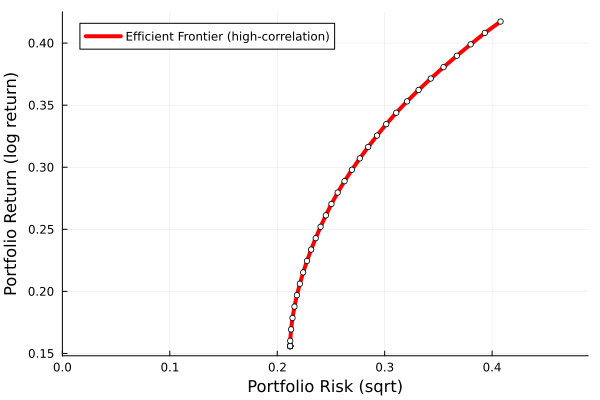

In [34]:
plot(efficient_frontier_high_correlation, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Return (log return)", fontsize=18, label="Efficient Frontier (high-correlation)", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_high_correlation).first))
scatter!(efficient_frontier_high_correlation, label="", c=:white, mec=:black, ms=3)

## Task 3: Compute the efficient frontier for the `low` correlation collection of tickers
Similar to the previous `high` correlation case, let's look up the position of the `low` correlation tickers in the `all_tickers` list and save these values in the `my_list_of_firm_ids_lc` variable.

In [36]:
my_list_of_firm_ids_lc = Array{Int64,1}();
for ticker ∈ my_low_correlation_ticker_array
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids_lc, firm_index)
end

Then, let's build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type using the `build(...)` method for the `low` correlation collection of tickers, passing in the data for the required fields for the `low` correlation portfolio. Store this problem object in the `problem_risk_low_correlation` variable.
* `Note`: we are again using the short-cut syntax to extract the correct covariance array `Σ` and the expected return vector `μ`, i.e., we pass in the indexes for the firms we are interested in (stored in the `my_list_of_firm_ids_hc` variable), and the correct version of the data gets returned from the short-cut methods.

In [38]:
problem_risk_low_correlation = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ(my_list_of_firm_ids_lc), # short-cut: extracts the correct covariance,
    μ = μ(my_list_of_firm_ids_lc), # short-cut: extracts the correct expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for`-loop. In particular, for each pass through the loop, we:
* Update the `problem_risk_low_correlation` variable with the minimum desired reward (set the `R` field)
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
    * We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier_low_correlation` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier_low_correlation` dictionary.

In [40]:
efficient_frontier_low_correlation = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_low_correlation.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk_low_correlation)

    # check: did this converge?
    status_flag = solution["status"];
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        efficient_frontier_low_correlation[key] = solution["reward"];
    end
end
efficient_frontier_low_correlation;

LoadError: BoundsError: attempt to access 10×2 Matrix{Float64} at index [11, 1]

### Visualize the `low` versus the `high` correlation efficient frontier

In [42]:
plot(efficient_frontier_low_correlation, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Return (log return)", fontsize=18, label="Efficient Frontier (low-correlation)", c=:gray69, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_low_correlation).first))
scatter!(efficient_frontier_low_correlation, label="", c=:white, mec=:black, ms=3)

plot!(efficient_frontier_high_correlation, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Return (log return)", fontsize=18, label="Efficient Frontier (high-correlation)", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_high_correlation).first))
scatter!(efficient_frontier_high_correlation, label="", c=:white, mec=:black, ms=3)

LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.